# Aim

**Develop a method to:**

**1) read the full mission `.mat` files,**

**2) bin the data onto a `depth x long` grid, and** 

**3) write the data to a (probably netCDF) file.**

# 1) Reading the full mission files

The full mission data are saved within the corresponding `V/glider/<glider>/mission<no>/matlabdata/mission<no>.mat` file, where `<glider> = henry` or `grampus` and `<no>` = the mission number. 

Let's import the appropriate modules:

In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import os
import re
import fnmatch
import scipy.io
import datetime as dt
import matplotlib.pyplot as plt
%matplotlib inline

## Generating a list of the `.mat` files

In [2]:
gliders = ['henry','grampus']
parentDirs = ['V:/glider/'+g for g in gliders]

missionDirs = []
for pdir in parentDirs:
    allContents = os.listdir(pdir)
    missionDirs += [pdir+'/'+mm+'/' for mm in fnmatch.filter(allContents,'mission[0-9]*')]

Selecting one file and figuring out the structure of the data/how best to read the files

In [5]:
mf = missionDirs[-2]
mno = re.search('\d*\.*\d',mf).group()
mfile = mf + 'matlabdata/mission'+mno+'.mat'

mat = scipy.io.loadmat(mfile)

## Method development to extract the required data

So what variable contains the data? Let's check Bruce's `extractAllYos.m` matlab script, which takes the data from this mat file and makes the individual yo files.

### `.mat` file details from `extractAllYos.m`

For the east and west transects there are the two following variables:

1. `<direction>YoRange` which Bruce refers to as `yoRange`
2. `<direction>bound` which Bruce refers to as `dataset`

Hence the `eastbound` and `westbound` variables contain the required data. The `<direction>YoRange` variables contain a list of the yo numbers for each transect (Bruce has figured that out in an earlier script). Most of the other variables are a single number, and they refer to which column of the `<direction>bound` data they represent. 

Does Bruce do anything with the data before splitting it into yos? $\rightarrow$ YES!

1. If the variable `m_science_clothesline_lag` is within the `.mat` file then 
    * the NaNs of that variable are set to zero.
    * where the absolute value of `m_science_clotheseline_lag` is < 20 and `x_yo_number` == `yo`, the indices are assigned to a variable called `lagOK`
2. If the variable `m_science_clothesline_lag` is NOT within the `.mat` file, then the `lagOK` variable contains the indices where `x_yo_number` == `yo`.

The above steps are to do with the different bays/computers on the glider that are recording data. They sometimes get out of sync with each other, and the above puts them back into sync. This is only relevant for the missions before Henry mission 8. At this point there was a software upgrade, which deals with the out-of-sync data itself (i.e. the `m_science_clothesline_lag` variable only exists for the missions before Henry mission 8).

### Proposed extraction protocol

Given the above information, and the fact I am aiming to make a DataFrame which contains the data that are in the individual yo files, I'm going to try the following approach:

1. Identify the names of the variables within the `.mat` file that correspond to the data I want to extract 

2. Index the `<direction>bound` matrices using the values for the variables identified in the above step and correcting for the lag in the earlier missions are Bruce did above.

3. Create a DataFrame from the above data.

### 1. Identifying the names of the variables within the `.mat` file

The variables I want in my final DataFrame are:

In [4]:
variablefile = 'V:/Catherine/Glider/DataFiles/Glider Yo Columns.xlsx'
variables = pd.read_excel(variablefile,sheet_name='new',header=None,usecols=[4],squeeze=True)    
variables = list(variables.drop(variables.index[0]))
print(variables)

['year', 'day of year', 'time of day', 'lat ', 'lon', 'depth', 'bb', 'Lu380', 'Lu412', 'Lu443', 'Lu490', 'Lu510', 'Lu532', 'Lu555', 'Lu670', 'Ed380', 'Ed412', 'Ed443', 'Ed490', 'Ed510', 'Ed532', 'Ed555', 'Ed670', 'sigmaT', 'pitch', 'roll', 'chlfl', 'cdomfl', 'temp', 'sal', 'O2 conc', 'O2 saturation', 'nitrate']


I need to match the variables as they are named within the yo files (the above list) to the names of the variables within the `.mat` files (below):

In [5]:
print(mat.keys())

dict_keys(['__header__', '__version__', '__globals__', 'missionNumber', 'x_sci_salinity', 'x_sci_sigmat', 'x_corrected_lat', 'x_corrected_lon', 'x_yo_number', 'mission', 'data', 'sci_ocr507R_rad1', 'sci_bbfl2s_bb_scaled', 'sci_water_pressure', 'sci_water_cond', 'sci_water_temp', 'm_lat', 'm_lon', 'm_gps_lat', 'm_gps_lon', 'm_present_time', 'sci_ocr507I_irrad1', 'run_name', 'start', 'm_present_secs_into_mission', 'm_num_half_yos_in_segment', 'm_tot_horz_dist', 'm_roll', 'm_pitch', 'm_heading', 'm_vehicle_temp', 'm_pressure', 'm_battery', 'm_vacuum', 'm_gps_speed', 'm_gps_heading', 'm_gps_mag_var', 'm_system_clock_lags_gps', 'm_avg_system_clock_lags_gps', 'sci_m_present_time', 'm_science_clothesline_lag', 'sci_bbfl2s_chlor_scaled', 'sci_bbfl2s_cdom_scaled', 'sci_ocr507R_rad2', 'sci_ocr507R_rad3', 'sci_ocr507R_rad4', 'sci_ocr507R_rad5', 'sci_ocr507R_rad6', 'sci_ocr507R_rad7', 'sci_ocr507I_irrad2', 'sci_ocr507I_irrad3', 'sci_ocr507I_irrad4', 'sci_ocr507I_irrad5', 'sci_ocr507I_irrad6', 'sci

OK, so the search terms for the variables I want are (the lat, lon and time variables were chosen to match the ones Bruce uses in the `extractAllYos.m` script):

In [5]:
searchKeys = ['sci_ocr*','sci_bbfl2s*','m_present_time','x_corrected_lat','x_corrected_lon','x_measured_depth',
              'x_sci_sigmat','m_pitch','m_roll','sci_water_temp','x_sci_salinity']
o2searchKeys = ['sci_oxy4']

And selecting these variables out of the list of all the variables:

In [6]:
matchedVariables = []
for key in searchKeys:
    for matkey in mat.keys():
        M = re.match(key,matkey)
        if M:
            matchedVariables += [matkey]

In [7]:
matchedVariables

['sci_ocr507R_rad1',
 'sci_ocr507I_irrad1',
 'sci_ocr507R_rad2',
 'sci_ocr507R_rad3',
 'sci_ocr507R_rad4',
 'sci_ocr507R_rad5',
 'sci_ocr507R_rad6',
 'sci_ocr507R_rad7',
 'sci_ocr507I_irrad2',
 'sci_ocr507I_irrad3',
 'sci_ocr507I_irrad4',
 'sci_ocr507I_irrad5',
 'sci_ocr507I_irrad6',
 'sci_ocr507I_irrad7',
 'sci_bbfl2s_bb_scaled',
 'sci_bbfl2s_chlor_scaled',
 'sci_bbfl2s_cdom_scaled',
 'm_present_time',
 'x_corrected_lat',
 'x_corrected_lon',
 'x_measured_depth',
 'x_sci_sigmat',
 'm_pitch',
 'm_roll',
 'sci_water_temp',
 'x_sci_salinity']

### 2. Selecting required variables from `<direction>bound` and formating the data

First we need to find the index of each variable in the `<direction>bound` arrays, then index appropriately.

In [8]:
eastData = {}
westData = {}
for vv in matchedVariables:
    ix = mat[vv][0][0]
    eastData[vv] = mat['eastbound'][:,ix-1]
    westData[vv] = mat['westbound'][:,ix-1]
    
eastData = pd.DataFrame(eastData)
westData = pd.DataFrame(westData)

OK, do these look reasonable?

In [36]:
#eastData.to_csv('eastBound-raw.csv')
eastData

,m_pitch,m_present_time,m_roll,sci_bbfl2s_bb_scaled,sci_bbfl2s_cdom_scaled,sci_bbfl2s_chlor_scaled,sci_ocr507I_irrad1,sci_ocr507I_irrad2,sci_ocr507I_irrad3,sci_ocr507I_irrad4,...,sci_ocr507R_rad4,sci_ocr507R_rad5,sci_ocr507R_rad6,sci_ocr507R_rad7,sci_water_temp,x_corrected_lat,x_corrected_lon,x_measured_depth,x_sci_salinity,x_sci_sigmat
0,-0.009809,1.217860e+09,0.010655,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.123850,2.151900,2.044700,1.624540,NaN,43.848421,-69.673048,0.035111,NaN,NaN
1,-0.184968,1.217861e+09,0.013161,0.000000,0.0000,0.0000,0.00000,0.00000,0.00000,0.00000,...,2.123850,2.151900,2.044700,1.624540,10.0000,43.852614,-69.673339,0.585506,26.860731,20.608267
2,-0.243830,1.217861e+09,0.224298,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.609968,NaN,NaN
3,NaN,1.217861e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.357194,NaN,NaN
4,NaN,1.217861e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,43.852741,-69.673117,NaN,NaN,NaN
5,NaN,1.217882e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.149267,NaN,NaN
6,0.524292,1.217884e+09,0.007852,NaN,1.6031,0.6897,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,19.3579,43.557690,-69.773041,4.580970,31.377180,22.186084
7,0.421608,1.217884e+09,-0.002128,0.004701,1.5088,0.6171,33.74890,45.86010,NaN,NaN,...,0.294016,0.278329,0.236190,0.008063,19.5200,43.557675,-69.773037,2.314150,31.381100,22.138066
8,-0.073743,1.217884e+09,-0.009205,0.004166,1.4145,0.5324,30.15480,37.43990,40.29620,31.93660,...,0.381274,0.358122,0.303202,0.014530,20.2061,43.557646,-69.773067,2.293770,31.286866,21.890049
9,-0.085109,1.217884e+09,-0.009740,0.004701,1.4145,0.5082,39.87050,45.34730,58.48640,38.04100,...,0.459204,0.436379,0.369877,0.022072,20.5676,43.557640,-69.773079,2.730010,31.268642,21.783688


OK, let's do Bruce's lag correction:

In [25]:
if 'm_science_clothesline_lag' in mat.keys():
    ix = mat['m_science_clothesline_lag'][0][0]
    lagE = mat['eastbound'][:,ix-1]
    lagE[np.isnan(lagE)] = 0
    lagW = mat['westbound'][:,ix-1]
    lagW[np.isnan(lagW)] = 0

On looking at what Bruce does next... I'm actually not exactly sure what is going and which parts are only relevant for splitting the data up into yos. So I decided to look for his script that makes the seabass formatted files (even though he hasn't run that on all the missions yet). It doesn't have anything about this lag correction and selects data based on temp, sal and latitude values: 

1. Only finite values of `latitude` are kept i.e. no `NaN` values
2. Only take the data where `temperature ~= 0` and `~(salinity < 0 & salinity > -1)`
3. If any given row (i.e. measurment) has 7 or more `NaN` values, then it is discarded.

I think I am just going to follow this procedure.

In [9]:
subData_E = eastData.loc[np.isfinite(eastData['x_corrected_lat'])].copy()
idx = ~((subData_E['sci_water_temp'] == 0) & (subData_E['x_sci_salinity'] < 0) & (subData_E['x_sci_salinity'] > -1))
subData_E = subData_E.loc[idx].copy()
subData_E.dropna(thresh=19,inplace = True)

In [65]:
#subData_E.to_csv('eastBound-raw2.csv')
subData_E

,m_pitch,m_present_time,m_roll,sci_bbfl2s_bb_scaled,sci_bbfl2s_cdom_scaled,sci_bbfl2s_chlor_scaled,sci_ocr507I_irrad1,sci_ocr507I_irrad2,sci_ocr507I_irrad3,sci_ocr507I_irrad4,...,sci_ocr507R_rad4,sci_ocr507R_rad5,sci_ocr507R_rad6,sci_ocr507R_rad7,sci_water_temp,x_corrected_lat,x_corrected_lon,x_measured_depth,x_sci_salinity,x_sci_sigmat
1,-0.184968,1.217861e+09,0.013161,0.000000,0.0000,0.0000,0.000000,0.000000,0.000000,0.00000,...,2.123850,2.151900,2.044700,1.624540,10.0000,43.852614,-69.673339,0.585506,26.860731,20.608267
8,-0.073743,1.217884e+09,-0.009205,0.004166,1.4145,0.5324,30.154800,37.439900,40.296200,31.93660,...,0.381274,0.358122,0.303202,0.014530,20.2061,43.557646,-69.773067,2.293770,31.286866,21.890049
9,-0.085109,1.217884e+09,-0.009740,0.004701,1.4145,0.5082,39.870500,45.347300,58.486400,38.04100,...,0.459204,0.436379,0.369877,0.022072,20.5676,43.557640,-69.773079,2.730010,31.268642,21.783688
36,0.268795,1.217884e+09,0.001316,0.006903,2.3575,2.4079,2.632570,5.871070,12.970600,14.21350,...,0.079935,0.082892,0.074137,0.003766,11.5615,43.557573,-69.772962,10.843200,32.343766,24.656797
37,0.260829,1.217884e+09,0.004275,0.007081,2.3575,1.9481,3.730170,7.882780,16.368000,16.42330,...,0.099453,0.102042,0.090760,0.004112,12.1665,43.557573,-69.772958,10.472200,32.175476,24.412850
38,0.257275,1.217884e+09,0.001925,0.007200,2.3575,1.8997,5.113520,10.141400,19.543800,19.42990,...,0.112986,0.115442,0.109934,0.004513,12.4771,43.557574,-69.772952,10.097200,32.093464,24.288931
39,0.252723,1.217884e+09,-0.000091,0.006248,2.2632,1.7787,5.912400,11.344400,21.012500,20.76330,...,0.135267,0.136870,0.120723,0.004760,13.4839,43.557574,-69.772949,9.758760,31.806962,23.869433
40,0.255514,1.217884e+09,0.004635,0.005058,1.9803,1.4641,6.844220,12.615500,22.295500,21.89000,...,0.146505,0.147496,0.129722,0.004953,15.9980,43.557574,-69.772944,9.387750,31.369591,23.000038
41,0.272901,1.217884e+09,0.003718,0.005058,1.7917,1.2100,8.148680,14.839400,25.909200,25.52830,...,0.157489,0.157766,0.138307,0.005115,16.4372,43.557574,-69.772942,9.086060,31.372863,22.902594
43,0.260275,1.217884e+09,0.006620,0.005118,1.7917,1.2221,NaN,NaN,NaN,NaN,...,0.170011,0.169677,0.148468,0.005319,16.6519,43.557573,-69.772935,8.429660,31.393129,22.866372


In [10]:
subData_W = westData.loc[np.isfinite(westData['x_corrected_lat'])].copy()
idx = ~((subData_W['sci_water_temp'] == 0) & (subData_W['x_sci_salinity'] < 0) & (subData_W['x_sci_salinity'] > -1))
subData_W = subData_W.loc[idx].copy()
subData_W.dropna(thresh=19,inplace = True)

So we know have the data into dataframes, but we need to split up the date-time number into something a bit more useful e.g. fractional day of year. Currently the date-time numbers are unix times.

In [11]:
year_E = []
jday_E = []
for unixTime in subData_E['m_present_time']:
    pythonDT = dt.datetime.utcfromtimestamp(unixTime)
    year_E += [pythonDT.year]
    jday = pythonDT.timetuple().tm_yday
    fractionalDay = (pythonDT.hour/24.) + (pythonDT.minute/60/24) + (pythonDT.second/60/60/24) 
    jday_E += [jday+fractionalDay]
subData_E['year'] = year_E
subData_E['day'] = jday_E
subData_E.drop(['m_present_time'],axis = 1, inplace = True)

In [12]:
year_W = []
jday_W = []
for unixTime in subData_W['m_present_time']:
    pythonDT = dt.datetime.utcfromtimestamp(unixTime)
    year_W += [pythonDT.year]
    jday = pythonDT.timetuple().tm_yday
    fractionalDay = (pythonDT.hour/24.) + (pythonDT.minute/60/24) + (pythonDT.second/60/60/24) 
    jday_W += [jday+fractionalDay]
subData_W['year'] = year_W
subData_W['day'] = jday_W
subData_W.drop(['m_present_time'],axis = 1, inplace = True)

# 2) Bin the data on a `lon x depth` grid

Need to choose sensible longitude and depth bins. I want them to be small enough that we still have pretty high resolution data.

Depth bins = 1 m from 0 to 200 m

Lon bins = 0.01 degrees from -69.77 to -66.8

In [13]:
zbins = np.linspace(0,200,num=201)
lonbins = np.linspace(-69.78,-66.8,num=int((-66.8+69.78)/0.01))

zlabels = [str(z) for z in range(len(zbins)-1)]
lonlabels = [str(i) for i in range(len(lonbins)-1)]

In [14]:
subData_E['zbin'] = pd.cut(subData_E['x_measured_depth'].values,zbins,labels = zbins[1:])
subData_E['lonbin'] = pd.cut(subData_E['x_corrected_lon'].values,lonbins,labels = lonbins[1:])

subData_W['zbin'] = pd.cut(subData_W['x_measured_depth'].values,zbins,labels = zbins[1:])
subData_W['lonbin'] = pd.cut(subData_W['x_corrected_lon'].values,lonbins,labels = lonbins[1:])

In [23]:
binned_E = subData_E.groupby(['zbin','lonbin']).mean()
binned_W = subData_W.groupby(['zbin','lonbin']).mean()

binned_E.drop(['x_measured_depth','x_corrected_lon'],axis = 1, inplace=True)
binned_W.drop(['x_measured_depth','x_corrected_lon'],axis = 1, inplace=True)

In [24]:
dataE = xr.Dataset.from_dataframe(binned_E)
dataW = xr.Dataset.from_dataframe(binned_W)



In [25]:
varnames = {'sci_ocr507R_rad1' : 'Lu412','sci_ocr507R_rad2' : 'Lu443','sci_ocr507R_rad3' : 'Lu490',
           'sci_ocr507R_rad4' : 'Lu510','sci_ocr507R_rad5' : 'Lu532','sci_ocr507R_rad6' : 'Lu555',
           'sci_ocr507R_rad7' : 'Lu670',
           'sci_ocr507I_irrad1' : 'Ed412','sci_ocr507I_irrad2' : 'Ed443','sci_ocr507I_irrad3' : 'Ed490',
           'sci_ocr507I_irrad4' : 'Ed510','sci_ocr507I_irrad5' : 'Ed532','sci_ocr507I_irrad6' : 'Ed555',
           'sci_ocr507I_irrad7' : 'Ed670',
           'sci_bbfl2s_bb_scaled' : 'bb532','sci_bbfl2s_chlor_scaled' : 'chlfl','sci_bbfl2s_cdom_scaled' : 'cdomfl',
           'x_corrected_lat' : 'lat',
           'sci_water_temp' : 'temp', 'x_sci_salinity' : 'sal', 'x_sci_sigmat' : 'sigmat',
           'm_pitch' : 'pitch', 'm_roll' : 'roll'}

dataE = dataE.rename(varnames)
dataW = dataW.rename(varnames)

In [37]:
dataE

<xarray.Dataset>
Dimensions:  (lonbin: 297, zbin: 200)
Coordinates:
  * zbin     (zbin) float64 1.0 2.0 3.0 4.0 5.0 ... 197.0 198.0 199.0 200.0
  * lonbin   (lonbin) float64 -69.77 -69.76 -69.75 ... -66.82 -66.81 -66.8
Data variables:
    pitch    (zbin, lonbin) float64 nan -0.05056 nan nan nan ... nan nan nan nan
    roll     (zbin, lonbin) float64 nan -0.004747 nan nan ... nan nan nan nan
    bb532    (zbin, lonbin) float64 nan 0.00421 nan nan nan ... nan nan nan nan
    cdomfl   (zbin, lonbin) float64 nan 1.815 nan nan nan ... nan nan nan nan
    chlfl    (zbin, lonbin) float64 nan 0.9438 nan nan nan ... nan nan nan nan
    Ed412    (zbin, lonbin) float64 nan 0.007869 nan nan nan ... nan nan nan nan
    Ed443    (zbin, lonbin) float64 nan -0.002782 nan nan ... nan nan nan nan
    Ed490    (zbin, lonbin) float64 nan 0.004328 nan nan nan ... nan nan nan nan
    Ed510    (zbin, lonbin) float64 nan -0.002815 nan nan ... nan nan nan nan
    Ed532    (zbin, lonbin) float64 nan -0.0003671 

So how do these results look cf those using the unbinned data that Bruce makes and puts on modis.bigelow.org?

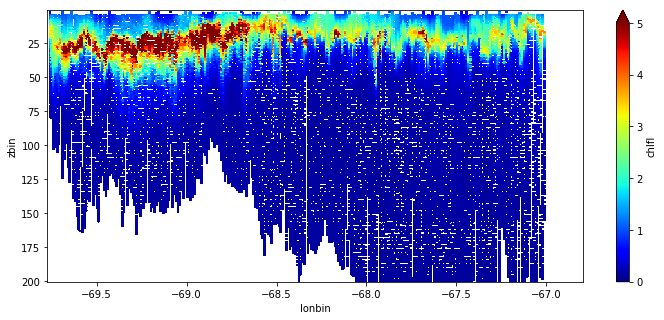

In [36]:
plt.figure(figsize=(12,5))
dataW['chlfl'].plot(yincrease=False,vmax = 5, vmin = 0, cmap = 'jet')


Pretty comparable, but there seems to be more gaps... perhaps we could use a slightly larger longitude bin!

Before going up and changing the bin size then running all the cells again, I think I am going to consolidate the above into a concise, script-like form (ready for running on more missions!), then can try adjusting the lon bin a bit more. Note that to fully do this concise script/function, I'll need to consider the grampus case and the extra sensors... but I'll leave that out for now.

# 3) Consolidating binning method into one function

In [61]:
def binMatFile(mat):
    # finding the variables as named by Bruce
    variablefile = 'V:/Catherine/Glider/DataFiles/Glider Yo Columns.xlsx'
    variables = pd.read_excel(variablefile,sheet_name='new',header=None,usecols=[4],squeeze=True)    
    variables = list(variables.drop(variables.index[0]))

    #finding the required variables based on their default names
    searchKeys = ['sci_ocr*','sci_bbfl2s*','m_present_time','x_corrected_lat','x_corrected_lon','x_measured_depth',
                  'x_sci_sigmat','m_pitch','m_roll','sci_water_temp','x_sci_salinity']

    matchedVariables = []
    for key in searchKeys:
        for matkey in mat.keys():
            M = re.match(key,matkey)
            if M:
                matchedVariables += [matkey]

    #dealing with east and west bound data separately
    missionList = []
    directions = ['east','west']
    for direction in directions:

        dirBound = direction + 'bound'

        #selecting required variables from the <direction>bound matrices
        Data = {}
        for vv in matchedVariables:
            ix = mat[vv][0][0]
            Data[vv] = mat[dirBound][:,ix-1]

        Data = pd.DataFrame(Data)

        #doing some QC on the data
        subData = Data.loc[np.isfinite(Data['x_corrected_lat'])].copy()
        idx = ~((subData['sci_water_temp'] == 0) & (subData['x_sci_salinity'] < 0) & (subData['x_sci_salinity'] > -1))
        subData = subData.loc[idx].copy()
        subData.dropna(thresh=19,inplace = True)

        #reformatting the datetime string from unix time to year and decimal day of year
        year = []
        jdays = []
        for unixTime in subData['m_present_time']:
            pythonDT = dt.datetime.utcfromtimestamp(unixTime)
            year += [pythonDT.year]
            jday = pythonDT.timetuple().tm_yday
            fractionalDay = (pythonDT.hour/24.) + (pythonDT.minute/60/24) + (pythonDT.second/60/60/24) 
            jdays += [jday+fractionalDay]
        subData['year_'+direction] = year
        subData['day_'+direction] = jdays
        subData.drop(['m_present_time'],axis = 1, inplace = True)

        #specifying the depth and longitude bins
        zbins = np.linspace(0,200,num=201)
        lonbins = np.linspace(-69.78,-66.8,num=int((-66.8+69.78)/0.01))

        zlabels = [str(z) for z in range(len(zbins)-1)]
        lonlabels = [str(i) for i in range(len(lonbins)-1)]

        #doing the binning
        subData['zbin'] = pd.cut(subData['x_measured_depth'].values,zbins,labels = zbins[1:])
        subData['lonbin'] = pd.cut(subData['x_corrected_lon'].values,lonbins,labels = lonbins[1:])
        binned = subData.groupby(['zbin','lonbin']).mean()

        #reformatting into xarray
        binned.drop(['x_measured_depth','x_corrected_lon'],axis = 1, inplace=True)
        data = xr.Dataset.from_dataframe(binned)

        #renaming the variables
        varnames = {'sci_ocr507R_rad1' : 'Lu412_'+direction,'sci_ocr507R_rad2' : 'Lu443_'+direction,
                    'sci_ocr507R_rad3' : 'Lu490_'+direction,'sci_ocr507R_rad4' : 'Lu510_'+direction,
                    'sci_ocr507R_rad5' : 'Lu532_'+direction,'sci_ocr507R_rad6' : 'Lu555_'+direction,
                    'sci_ocr507R_rad7' : 'Lu670_'+direction,
                    'sci_ocr507I_irrad1' : 'Ed412_'+direction,'sci_ocr507I_irrad2' : 'Ed443_'+direction,
                    'sci_ocr507I_irrad3' : 'Ed490_'+direction,'sci_ocr507I_irrad4' : 'Ed510_'+direction,
                    'sci_ocr507I_irrad5' : 'Ed532_'+direction,'sci_ocr507I_irrad6' : 'Ed555_'+direction,
                    'sci_ocr507I_irrad7' : 'Ed670_'+direction,'sci_bbfl2s_bb_scaled' : 'bb532_'+direction,
                    'sci_bbfl2s_chlor_scaled' : 'chlfl_'+direction,'sci_bbfl2s_cdom_scaled' : 'cdomfl_'+direction,
                    'x_corrected_lat' : 'lat_'+direction,
                    'sci_water_temp' : 'temp_'+direction, 'x_sci_salinity' : 'sal_'+direction, 
                    'x_sci_sigmat' : 'sigmat_'+direction,
                    'm_pitch' : 'pitch_'+direction, 'm_roll' : 'roll_'+direction}

        data = data.rename(varnames)

        missionList += [data]

    fullMission = xr.merge(missionList)
    
    return fullMission

Does this function work? 

Yes it did, so I am now playing with the lon bin size...

In [62]:
fullMission = binMatFile(mat)

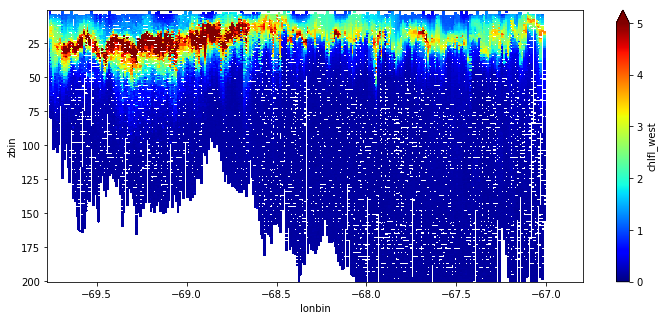

In [63]:
plt.figure(figsize=(12,5))
fullMission['chlfl_west'].plot(yincrease=False,vmax = 5, vmin = 0, cmap = 'jet')

Even though increasing the bin size does decrease the amount of white space, I think keeping the long bin at 0.01 is good. It equates to around 1km, which I think is reasonable. The idea here is to get the data onto the same sized grid without having to do too much averaging, so this is OK.

The final steps are

1. to write the binned data to a file
2. to add in the Grampus specific parts
3. run on all the missions!

# 4) Creating one workflow

Above I wrote a function for the binning which takes the mat file as an input, so I need to write a script which will deal with the file handling, and do the binning. I am going to write this script separately. Infact, I am going to write two scripts:

1. **`binGliderMatFile.py`** which will contain the above function (adapted to include the Grampus specifics), and a bit of the file handling, so in future missions I can just provide one directory to the script.
2. **`batchBinGliderMissions.py`** which will do the file handling, etc for the files to date.

THE SCRIPTS AREN'T WORKING FOR GRAMPUS BUT I AM STOPPING THIS FOR NOW AND JUST PROCEEDING WITH THE HENRY FILES

**This Grampus problem was fixed - see `LabBook-v2a` for details**